# Пример построенной нейронной сети при помощи PyTorch

Задача: восстановление пропусков в спутниковых снимках для территории 1 градус широты на 1 градус долготы (г. Мадрид). Массивы данных для обучения и валидации уже стандартизированны. Минимальными значениями в каждой матрице хакодированы пропуски.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

from pylab import rcParams
rcParams['figure.figsize'] = 5, 5

import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

Определим параметры для воспроизводимости результатов в будущем.

In [2]:
random_seed = 100
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
# Загружаем данные 
X = np.load('D:/Madrid_LST_neural_network/Train/X.npy')
Y = np.load('D:/Madrid_LST_neural_network/Train/Y.npy')

# Разделяем на "обучение" и "тест" и переводим в тензоры
X_train = torch.from_numpy(X[:2000,:,:,0])
X_test = torch.from_numpy(X[2000:, :, :,0])
Y_train = torch.from_numpy(Y[:2000,:,:,0])
Y_test = torch.from_numpy(Y[2000:, :, :,0])

# Меняем форму тензоров 
X_train = torch.reshape(X_train, (2000, 1, 110, 88))
X_test = torch.reshape(X_test, (658, 1, 110, 88))
Y_train = torch.reshape(Y_train, (2000, 1, 110, 88))
Y_test = torch.reshape(Y_test, (658, 1, 110, 88))

print(f'Размерность массива в обучающей выборке {Y_train.shape}')
print(f'Размерность массива в тестовой выборке {Y_test.shape}')

Размерность массива в обучающей выборке torch.Size([2000, 1, 110, 88])
Размерность массива в тестовой выборке torch.Size([658, 1, 110, 88])


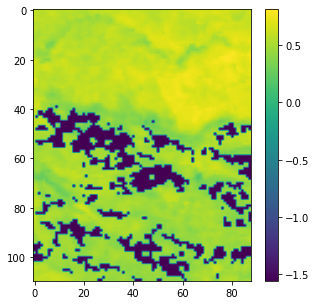

In [4]:
# Проверим корректность их отображения
plt.imshow(X_train[13,0,:,:])
plt.colorbar()
plt.show()

In [5]:
# Prepare data loaders
train_loader = torch.utils.data.DataLoader(X_train, batch_size=32, num_workers=0)
test_loader = torch.utils.data.DataLoader(X_test, batch_size=32, num_workers=0)

In [14]:
# Define the Convolutional Autoencoder
class ConvNet(nn.Module):
    def __init__(self):
        
        # Переопределяем методы родительского класса для автоэнкодера
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=2, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=2, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(kernel_size=2, stride=1))
        self.layer3 = nn.Sequential(nn.Conv2d(32, 16, kernel_size=2, stride=1, padding=1), nn.ReLU(), 
                                    nn.Upsample(scale_factor=0.99, mode='nearest'))
        self.drop_out = nn.Dropout(0.1)
        self.layer4 = nn.Sequential(nn.Conv2d(16, 1, kernel_size=2, stride=1, padding=1), nn.ReLU(), 
                                    nn.Upsample(scale_factor=1.97, mode='bilinear'))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.drop_out(out)
        out = self.layer4(out)
        return(out)
    
#Instantiate the model
model = ConvNet()
print(model)

#Loss function
criterion = nn.MSELoss()

#Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=0.99, mode=nearest)
  )
  (drop_out): Dropout(p=0.1, inplace=False)
  (layer4): Sequential(
    (0): Conv2d(16, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=1.97, mode=bilinear)
  )
)


Обучать нейронную сеть мы будем на видеокарте

In [15]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
model.to(device)

#Epochs
n_epochs = 5

for epoch in range(1, n_epochs+1):
    train_loss = 0.0

    # Обучение
    for data in train_loader:
        # Батч из нескольких матриц 
        images = data
        # Переносим эти матрицы на GPU
        images = images.to(device)
        # Обновляем градиенты 
        optimizer.zero_grad()
        
        # Выход нейронной сети
        outputs = model(images)      
        # Замеряем разницу между действительными значениями и предсказанием
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.3f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 25.611
Epoch: 2 	Training Loss: 23.801
Epoch: 3 	Training Loss: 23.636
Epoch: 4 	Training Loss: 23.557
Epoch: 5 	Training Loss: 23.501


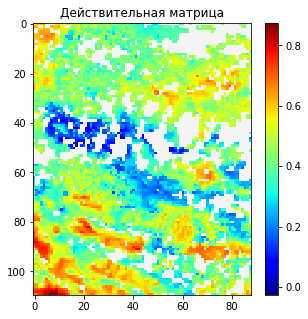

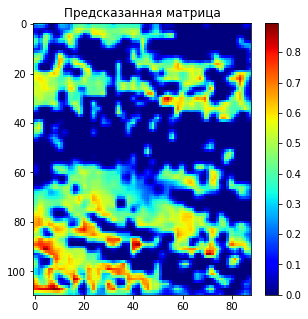

In [16]:
example_index = 15

cpu_real = X_test[example_index, :, :, :].cpu()
actual_matrix = cpu_real.data.numpy()
actual_matrix = actual_matrix[0,:,:]

masked_array = np.ma.masked_where(actual_matrix == np.min(actual_matrix), actual_matrix)
cmap = cm.get_cmap('jet')
cmap.set_bad(color='#F4F4F4')
plt.imshow(masked_array, interpolation='nearest', cmap = cmap)
plt.title('Действительная матрица')
plt.colorbar()
plt.show()


# then put it on the GPU, make it float and insert a fake batch dimension
test_value = Variable(X_test[example_index, :, :, :].cuda())
test_value = test_value.float()
test_value = test_value.unsqueeze(0)

# pass it through the model
prediction = model(test_value)

# get the result out and reshape it
cpu_pred = prediction.cpu()
result = cpu_pred.data.numpy()

plt.imshow(result[0,0,:,:], cmap = cmap, interpolation='nearest')
plt.title('Предсказанная матрица')
plt.colorbar()
plt.show()